In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
import shap
from functools import reduce

In [2]:
#Read-in custom function
import CleanSAO
from CleanFDOC import clean_fdoc
from CreateCCMaster import create_ccm
from CreateModelDF import model_df
from TreeModels import get_tree

In [4]:
dir = os.getcwd()
path = dir+'/data/'
os.chdir(path)

#Clean charges(prosecutor specific actions) datasets (drug, theft)
drug_sa_clean, theft_sa_clean = CleanSAO.clean_sao('CjdtSAOCase_00000.csv')

#Clean sentencing (offenses) datasets (drug, theft)
drug_offenses_clean, theft_offenses_clean = clean_fdoc(['Active_Offenses_PRPR.csv', 'Active_Offenses_CPS.csv', 
                                                       'Release_Offenses_PRPR.csv', 'Release_Offenses_CPS.csv', 
                                                       'Active_Root.csv', 'Release_Root.csv'])

#Circuit-county-year political/State Attorney dataset
ccm = create_ccm(safile = "SA_Political_Leanings.csv", 
                    housefile = "clean_house.csv", 
                    senatefile = "clean_senate.csv", 
                    presfile = "clean_pres.csv", 
                    circuitcountyfile="circuit_county_crosswalk.csv")
                    
# Compile modeling datasets
drug_sa_df = model_df(drug_sa_clean, ccm, obstype = 'action', crimetype = 'drug')
theft_sa_df = model_df(theft_sa_clean, ccm, obstype = 'action', crimetype = 'theft')
drug_off_df = model_df(drug_offenses_clean, ccm, obstype = 'offense', crimetype = 'drug')
theft_off_df = model_df(theft_offenses_clean, ccm, obstype = 'offense', crimetype = 'theft')


## CART Models

### CART Classifier - Drug Charges

Confusion matrix:
 [[  48  189]
 [   9 1212]] Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.20      0.33       237
           1       0.87      0.99      0.92      1221

    accuracy                           0.86      1458
   macro avg       0.85      0.60      0.63      1458
weighted avg       0.86      0.86      0.83      1458
 Accuracy: 0.8641975308641975
Feature Importance Table


,Importance,Features
81,0.256043,SA_NAME_Bernie McCabe
27,0.211825,OFFENSE_Drug Equip-Possess
7,0.158817,CHARGE_LEVEL_Felony
0,0.112998,CHARGE_DEGREE_First Degree
42,0.054556,OFFENSE_Marijuana-Possess
4,0.046151,CHARGE_DEGREE_Second Degree
47,0.030667,PCT_DEM_HOUSE
14,0.021412,RACE_White
26,0.019173,OFFENSE_Drug Abuse Prevention and Control
16,0.017370,SEX_Male


Histogram of Feature Importance


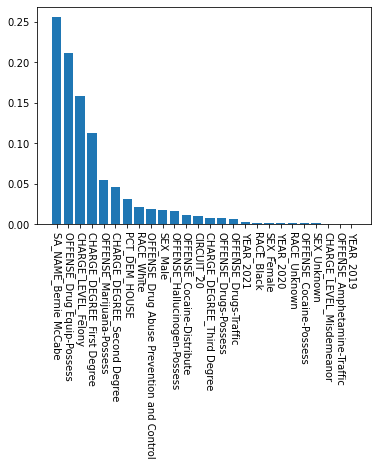

Feature Beeswarm Plot


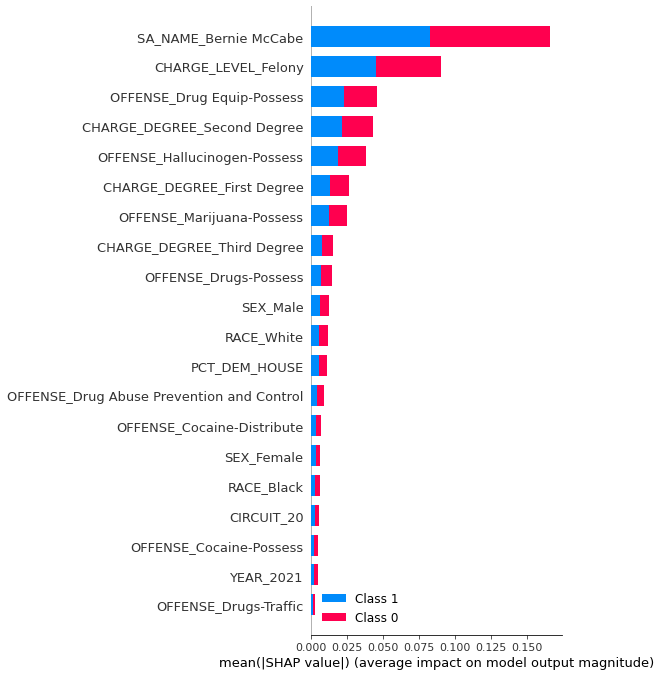

In [5]:
cart = {'max_depth':[3, 6, 10], 
        'min_samples_split':[8, 20], 
        'min_samples_leaf': [10, 20, 100]}

drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = cart, model = DecisionTreeClassifier,  seed = 42)

### CART Classifier - Theft Charges

Confusion matrix:
 [[  5  98]
 [  2 739]] Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.05      0.09       103
           1       0.88      1.00      0.94       741

    accuracy                           0.88       844
   macro avg       0.80      0.52      0.51       844
weighted avg       0.86      0.88      0.83       844
 Accuracy: 0.8815165876777251
Feature Importance Table


,Importance,Features
30,0.573790,PCT_DEM_HOUSE
4,0.235240,CHARGE_DEGREE_Second Degree
22,0.071874,OFFENSE_Larceny
8,0.054824,CHARGE_LEVEL_Misdemeanor
3,0.044836,CHARGE_DEGREE_Not Applicable
16,0.019436,SEX_Female


Histogram of Feature Importance


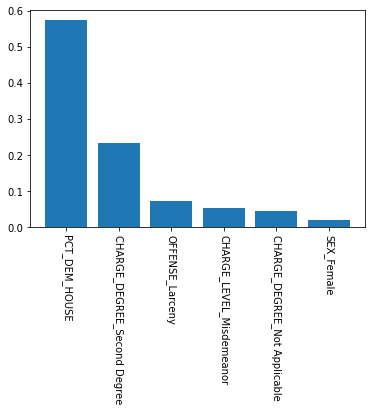

Feature Beeswarm Plot


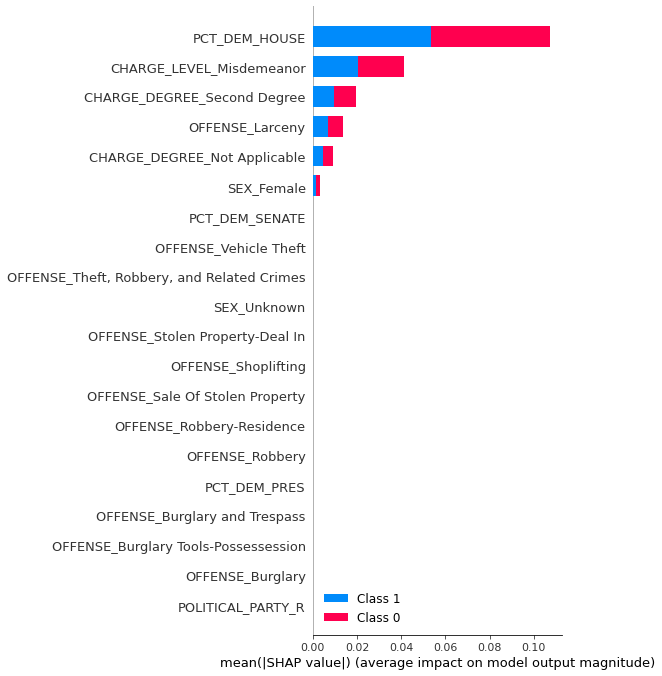

In [6]:
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = cart, model = DecisionTreeClassifier, seed = 42)

### CART Regressor - Drug Sentencing

train RMSE: 3.095397064432317 
test RMSE: 3.1896629709326603
Feature Importance Table


,Importance,Features
3,0.375679,POSSESSION
7,0.118662,NON-PRESCRIPTION_OPIOIDS
2,0.104234,AGE
4,0.063408,MARIJUANA
21,0.049927,SEX_M
24,0.048151,PCT_DEM_PRES
22,0.029917,PCT_DEM_HOUSE
23,0.025253,PCT_DEM_SENATE
119,0.018972,CIRCUIT_13.0
94,0.018060,COUNTY_VOLUSIA


Histogram of Feature Importance


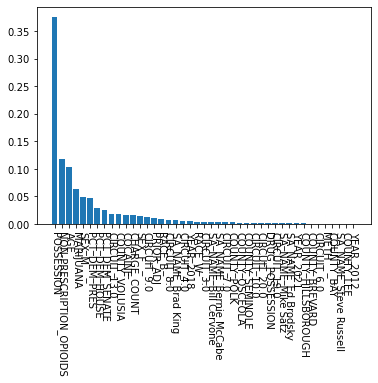

Feature Beeswarm Plot


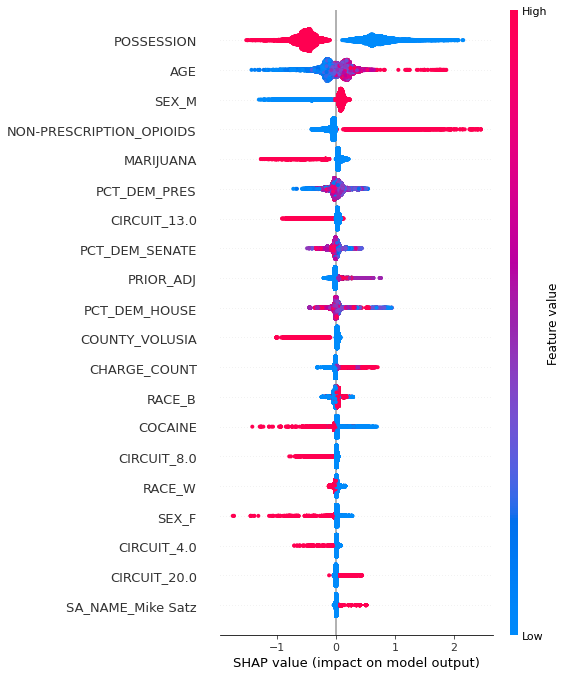

In [7]:
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = cart, model = DecisionTreeRegressor, seed = 42)

### CART Regressor - Theft Sentencing

train RMSE: 3.9170554956791563 
test RMSE: 3.985657882448129
Feature Importance Table


,Importance,Features
8,0.363025,ROBBERY
16,0.146809,NON-DEADLY_WEAPON
2,0.110107,AGE
15,0.093605,NO_WEAPON
14,0.085255,DEADLY_WEAPON
0,0.042273,CHARGE_COUNT
27,0.023322,PCT_DEM_PRES
3,0.018416,BURGLARY
26,0.016028,PCT_DEM_SENATE
23,0.015574,SEX_F


Histogram of Feature Importance


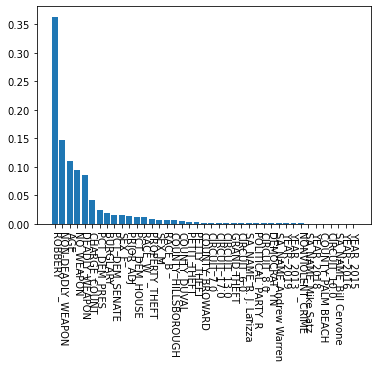

Feature Beeswarm Plot


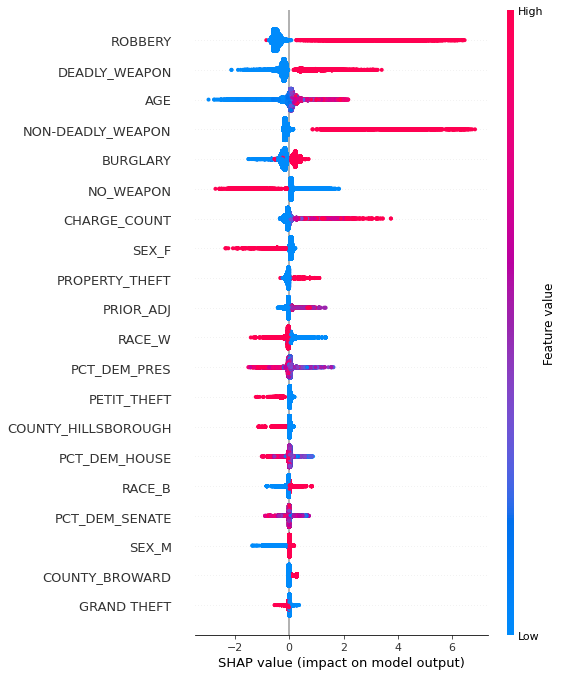

In [8]:
theft_off_tree = get_tree(theft_off_df, 'TERM_YEARS', paramdict = cart, model = DecisionTreeRegressor, seed = 42)

## Random Forest Models

### RF Classifier - Drug Charges

Confusion matrix:
 [[  45  192]
 [  16 1205]] Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.19      0.30       237
           1       0.86      0.99      0.92      1221

    accuracy                           0.86      1458
   macro avg       0.80      0.59      0.61      1458
weighted avg       0.84      0.86      0.82      1458
 Accuracy: 0.8573388203017832
Feature Importance Table


,Importance,Features
7,0.276330,CHARGE_LEVEL_Felony
27,0.202035,OFFENSE_Drug Equip-Possess
62,0.127718,COUNTY_PINELLAS
75,0.100969,CIRCUIT_6
81,0.067022,SA_NAME_Bernie McCabe
8,0.066094,CHARGE_LEVEL_Misdemeanor
42,0.044568,OFFENSE_Marijuana-Possess
49,0.023584,PCT_DEM_PRES
37,0.019727,OFFENSE_Hallucinogen-Possess
14,0.018944,RACE_White


Histogram of Feature Importance


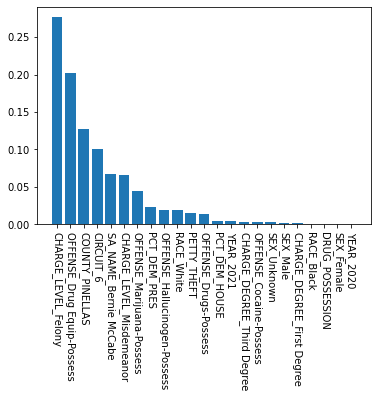

Feature Beeswarm Plot


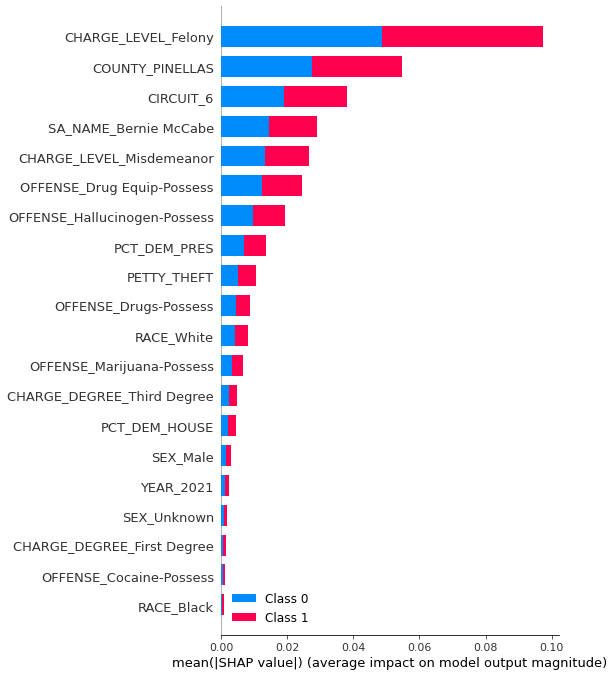

In [9]:
#RF hyperarameter space
bag = {'max_depth':[10, 15], 
        'min_samples_leaf': [100, 200], 
        'max_features': [40, 80], 
        'n_estimators':[15, 20]} 
        
drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = RandomForestClassifier, seed = 42)

### RF Classifier - Theft Charges


40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\ProgramData\Anaco

Confusion matrix:
 [[  0 103]
 [  0 741]] Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.88      1.00      0.94       741

    accuracy                           0.88       844
   macro avg       0.44      0.50      0.47       844
weighted avg       0.77      0.88      0.82       844
 Accuracy: 0.8779620853080569
Feature Importance Table


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Importance,Features
32,0.159540,PCT_DEM_PRES
19,0.118935,OFFENSE_Burglary
30,0.088298,PCT_DEM_HOUSE
22,0.087798,OFFENSE_Larceny
8,0.079552,CHARGE_LEVEL_Misdemeanor
53,0.075724,YEAR_2019
55,0.068065,YEAR_2021
54,0.066693,YEAR_2020
63,0.037704,SA_NAME_Bernie McCabe
7,0.036427,CHARGE_LEVEL_Felony


Histogram of Feature Importance


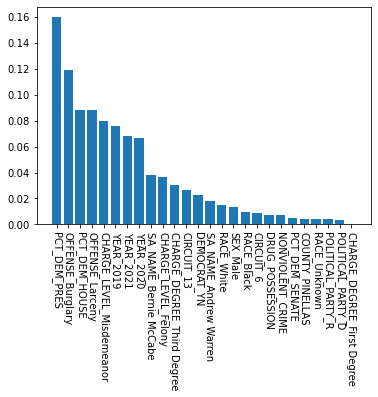

Feature Beeswarm Plot


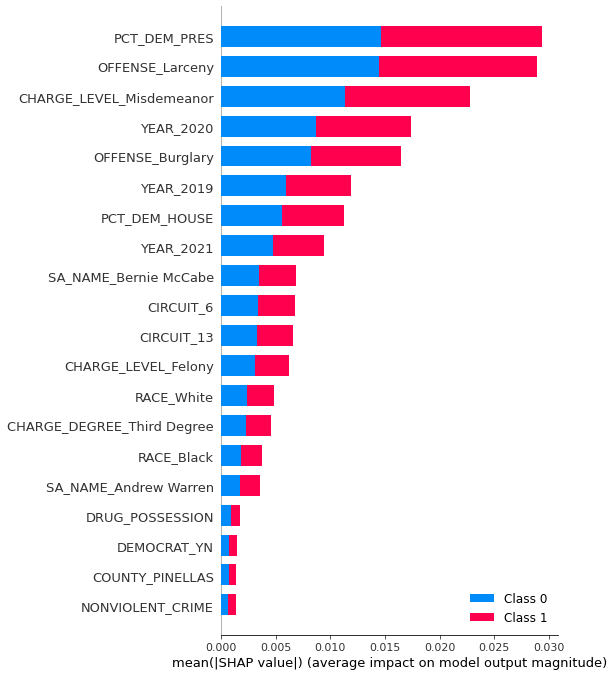

In [10]:
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = RandomForestClassifier, seed = 42)

### RF Regressor - Drug Charges

train RMSE: 3.0750664907114205 
test RMSE: 3.1701806859900636
Feature Importance Table


,Importance,Features
3,0.348333,POSSESSION
7,0.103840,NON-PRESCRIPTION_OPIOIDS
2,0.090793,AGE
4,0.063462,MARIJUANA
24,0.050611,PCT_DEM_PRES
...,...,...
73,0.000046,COUNTY_MONROE
58,0.000034,COUNTY_INDIAN RIVER
36,0.000029,COUNTY_CHARLOTTE
75,0.000025,COUNTY_OKALOOSA


Histogram of Feature Importance


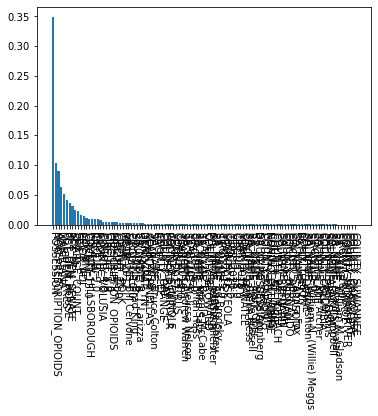

Feature Beeswarm Plot


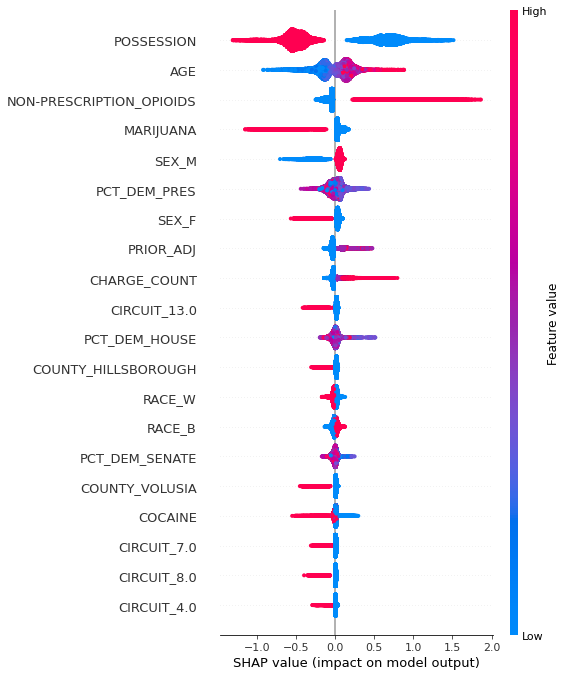

In [11]:
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = bag, model = RandomForestRegressor, seed = 42)

### RF Regressor - Theft Charges

train RMSE: 3.8921053328608 
test RMSE: 3.9502667128129887
Feature Importance Table


,Importance,Features
8,2.536840e-01,ROBBERY
16,1.510565e-01,NON-DEADLY_WEAPON
14,1.363828e-01,DEADLY_WEAPON
2,1.043347e-01,AGE
15,9.848255e-02,NO_WEAPON
...,...,...
121,1.062976e-05,CIRCUIT_12.0
91,7.731568e-06,COUNTY_ST. JOHNS
152,5.568020e-06,SA_NAME_Jeff Siegmeister
115,2.512912e-06,CIRCUIT_5.0


Histogram of Feature Importance


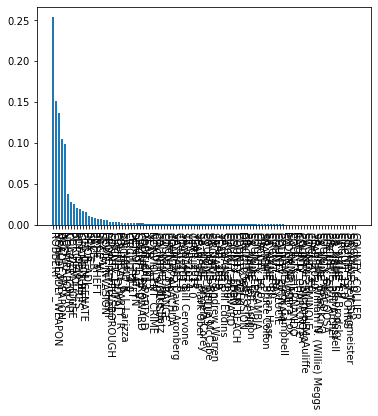

Feature Beeswarm Plot


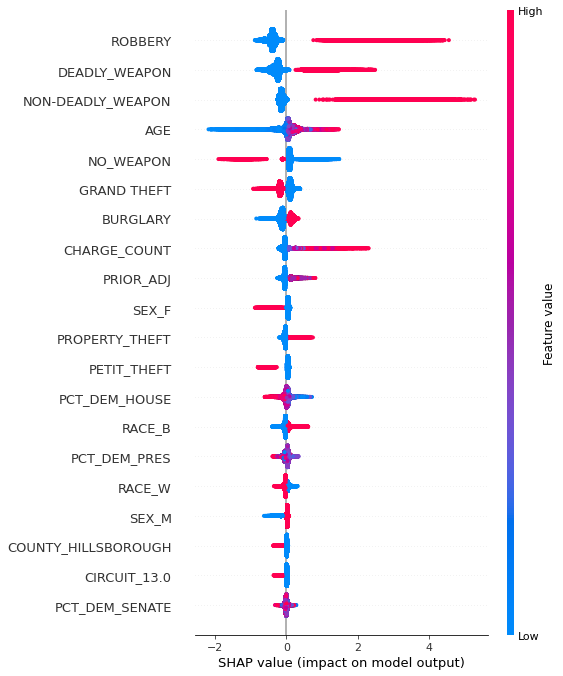

In [12]:
theft_off_tree = get_tree(theft_off_df, 'TERM_YEARS', paramdict = bag, model = RandomForestRegressor, seed = 42)

## XGBoost Models

### XGB Classifier - Drug Charges

Confusion matrix:
 [[  55  201]
 [  34 1168]] Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.21      0.32       256
           1       0.85      0.97      0.91      1202

    accuracy                           0.84      1458
   macro avg       0.74      0.59      0.61      1458
weighted avg       0.81      0.84      0.81      1458
 Accuracy: 0.8388203017832647
Feature Importance Table


,Importance,Features
64,0.210552,COUNTY_VOLUSIA
37,0.181287,OFFENSE_Hallucinogen-Possess
62,0.119848,COUNTY_PINELLAS
42,0.057983,OFFENSE_Marijuana-Possess
81,0.046652,SA_NAME_Bernie McCabe
0,0.039829,CHARGE_DEGREE_First Degree
8,0.037425,CHARGE_LEVEL_Misdemeanor
26,0.026139,OFFENSE_Drug Abuse Prevention and Control
4,0.023752,CHARGE_DEGREE_Second Degree
27,0.023718,OFFENSE_Drug Equip-Possess


Histogram of Feature Importance


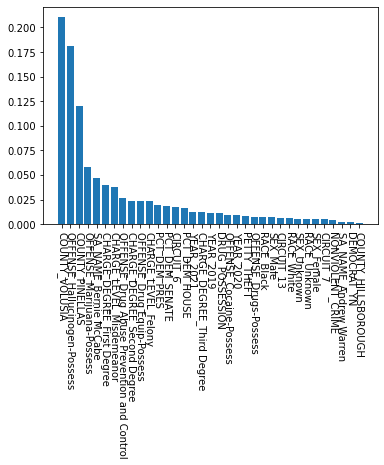

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Feature Beeswarm Plot


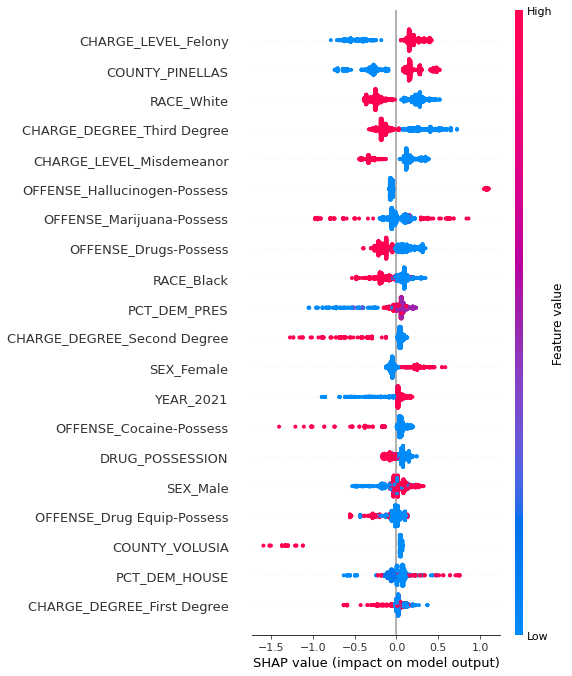

In [15]:
bag = {'max_depth':[4, 6], 
        'min_child_weight':[10, 20],
        'alpha': [0.1, 0.2],
        'colsample_bytree': [0.6, 0.75]} 

# XGB hyperparameter space
drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = XGBClassifier, seed =10)

### XGB Classifier - Theft Charges

Confusion matrix:
 [[ 16  89]
 [  4 735]] Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.15      0.26       105
           1       0.89      0.99      0.94       739

    accuracy                           0.89       844
   macro avg       0.85      0.57      0.60       844
weighted avg       0.88      0.89      0.86       844
 Accuracy: 0.8898104265402843
Feature Importance Table


,Importance,Features
65,0.385052,SA_NAME_R. J. Larizza
46,0.105756,COUNTY_VOLUSIA
31,0.048875,PCT_DEM_SENATE
44,0.039396,COUNTY_PINELLAS
23,0.029780,OFFENSE_Robbery
27,0.028457,OFFENSE_Stolen Property-Deal In
58,0.026575,CIRCUIT_7
8,0.026419,CHARGE_LEVEL_Misdemeanor
55,0.019185,YEAR_2021
18,0.018504,SEX_Unknown


Histogram of Feature Importance


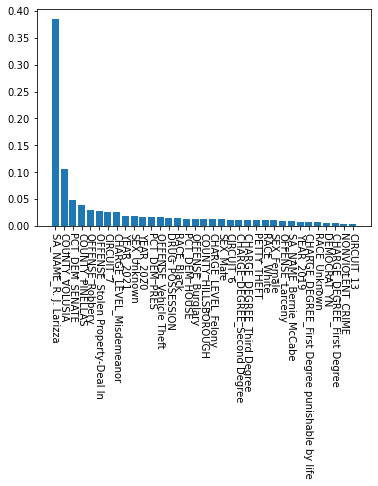

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Feature Beeswarm Plot


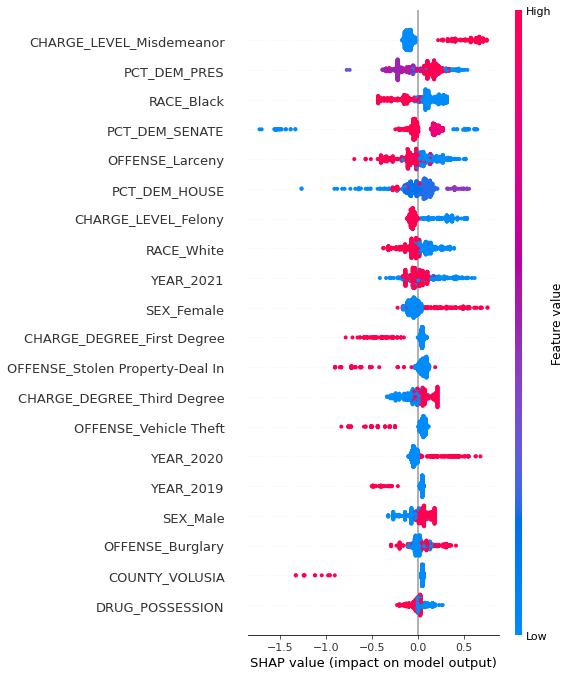

In [16]:
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = XGBClassifier,seed=10)

### XGB Regressor - Drug Charges

train RMSE: 2.792298127166822 
test RMSE: 3.1339048348190426
Feature Importance Table


,Importance,Features
121,0.046903,CIRCUIT_15.0
80,0.035520,COUNTY_PALM BEACH
56,0.032114,COUNTY_HILLSBOROUGH
3,0.026963,POSSESSION
133,0.024509,SA_NAME_Bill Eddins
...,...,...
47,0.000812,COUNTY_GADSDEN
10,0.000812,DATE_RAPE
14,0.000330,RACE_A
67,0.000324,COUNTY_LIBERTY


Histogram of Feature Importance


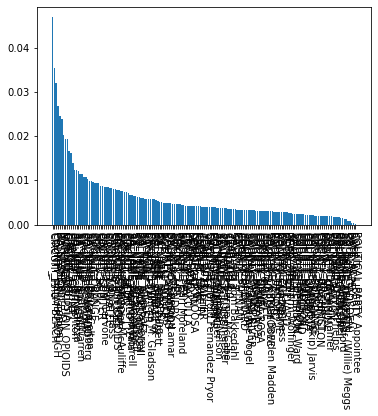

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Feature Beeswarm Plot


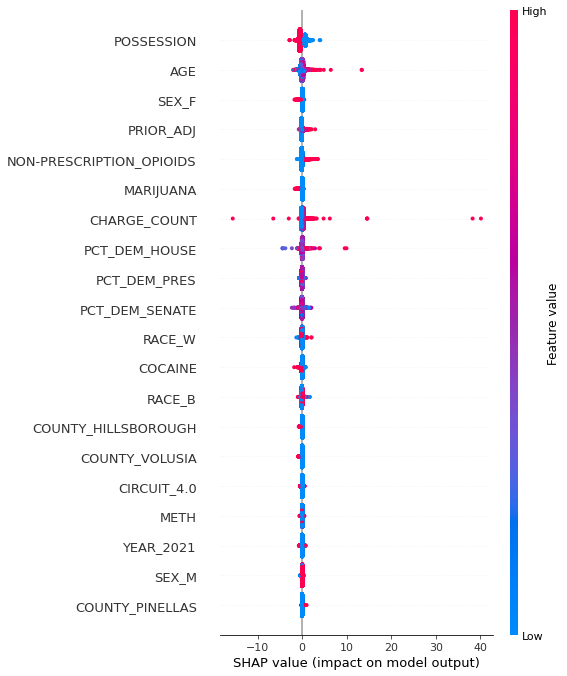

In [18]:
boost = {'max_depth':[8, 12], 
        'min_child_weight':[10, 20],
        'alpha': [0.1, 0.2],
        'colsample_bytree': [0.6, 0.75]}
        
# XGB Regressors
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = boost, model = XGBRegressor, seed=42)

### XGB Regressor - Theft Charges

train RMSE: 3.6627520954662947 
test RMSE: 3.911753631973393
Feature Importance Table


,Importance,Features
8,0.117143,ROBBERY
16,0.072479,NON-DEADLY_WEAPON
15,0.057819,NO_WEAPON
24,0.033785,SEX_M
37,0.025726,COUNTY_BROWARD
...,...,...
144,0.000659,SA_NAME_Dennis W. Ward
141,0.000455,SA_NAME_Catherine Vogel
71,0.000321,COUNTY_MADISON
13,0.000225,SUBSTANCE_THEFT


Histogram of Feature Importance


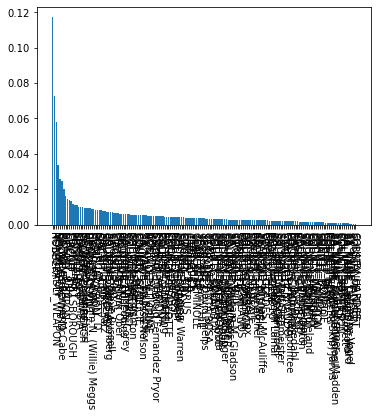

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Feature Beeswarm Plot


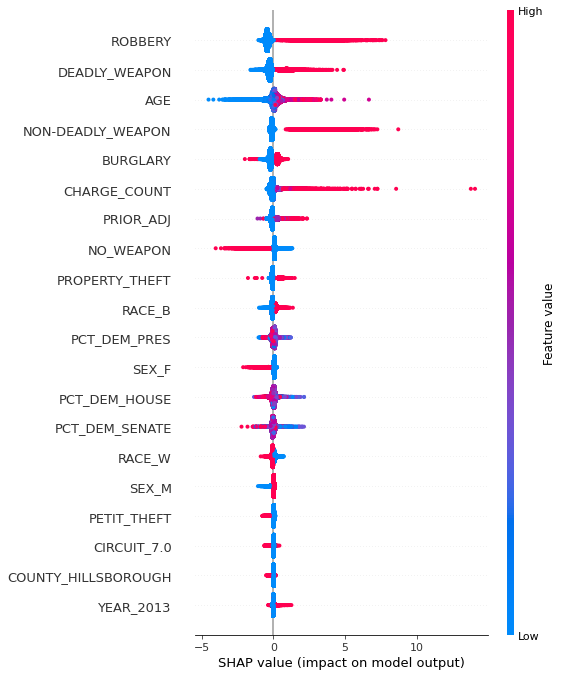

In [19]:
theft_off_tree = get_tree(theft_off_df, 'TERM_YEARS', paramdict = boost, model =XGBRegressor, seed = 42)